In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
print(tf.test.gpu_device_name())
# See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

/device:GPU:0


In [2]:
import os
import pandas as pd

import numpy as np
from glob import glob
import cv2
import skimage
from skimage.transform import resize

from keras import layers
from keras import models
from keras import optimizers
from keras.models import load_model
import keras.callbacks as kcall
from keras.optimizers import Adam
from keras.models import Model
from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [3]:
train_dir = 'data/train'
validation_dir = 'data/validation'

In [4]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

data/train 0
data/train/MEL 3308
data/train/DF 4152
data/train/BKL 3275
data/train/BCC 4773
data/train/VASC 3488
data/train/AKIEC 3856
data/train/NV 4975


In [5]:
for root,dirs,files in os.walk(validation_dir):
    print (root, len(files))

data/validation 0
data/validation/MEL 1664
data/validation/DF 1632
data/validation/BKL 1479
data/validation/BCC 1692
data/validation/VASC 1484
data/validation/AKIEC 1552
data/validation/NV 1730


In [6]:
from keras.preprocessing.image import ImageDataGenerator

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True)


# target_size = (height, width)
target_size = (225, 300)


train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size = target_size,       
        class_mode = 'categorical',
        shuffle = False)

validation_generator = train_datagen.flow_from_directory(
        validation_dir,
        target_size = target_size,        
        class_mode = 'categorical',
        shuffle = False)

Found 27827 images belonging to 7 classes.
Found 11233 images belonging to 7 classes.


In [7]:
import keras.backend as K

def precision(y_true, y_pred):
    # Calculates the precision
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    # Calculates the recall
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def fbeta_score(y_true, y_pred, beta=1):
    # Calculates the F score, the weighted harmonic mean of precision and recall.

    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')
        
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

def fmeasure(y_true, y_pred):
    # Calculates the f-measure, the harmonic mean of precision and recall.
    return fbeta_score(y_true, y_pred, beta=1)

In [8]:
## Intilizing variables
output_classes = 7

batch_size = 32 
epochs = 50
droput_rate= 0.5

adam_opt = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-5)
vgg16_weights= 'pretrained-models/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [10]:
from keras.applications.vgg19 import VGG19
from keras.layers import Flatten, Dense, Dropout, BatchNormalization
from keras.regularizers import l2

model = (VGG19(include_top=False, pooling='avg', weights=vgg16_weights))
x = model.output
# x = Flatten()(x)
x = Dense(1024, activation="relu", kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu", kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation="softmax", kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x)
model = Model(input = model.input, output = predictions)


model.compile(loss='categorical_crossentropy',
              optimizer= adam_opt,
              metrics = ["categorical_accuracy", fmeasure, recall, precision])


In [11]:
history = model.fit_generator(train_generator,
    steps_per_epoch=2048,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps=1024)

Epoch 1/50
2048/2048 [==============================] - 962s 470ms/step - loss: 1.5181 - categorical_accuracy: 0.5695 - fmeasure: 0.5586 - recall: 0.5098 - precision: 0.6232 - val_loss: 1.0773 - val_categorical_accuracy: 0.7099 - val_fmeasure: 0.7086 - val_recall: 0.6637 - val_precision: 0.7619
Epoch 2/50
2048/2048 [==============================] - 947s 463ms/step - loss: 0.6967 - categorical_accuracy: 0.8128 - fmeasure: 0.8138 - recall: 0.7877 - precision: 0.8427 - val_loss: 1.3626 - val_categorical_accuracy: 0.6686 - val_fmeasure: 0.6749 - val_recall: 0.6515 - val_precision: 0.7010
Epoch 3/50
2048/2048 [==============================] - 946s 462ms/step - loss: 0.4373 - categorical_accuracy: 0.8955 - fmeasure: 0.8963 - recall: 0.8841 - precision: 0.9094 - val_loss: 0.6727 - val_categorical_accuracy: 0.8384 - val_fmeasure: 0.8388 - val_recall: 0.8259 - val_precision: 0.8525
Epoch 4/50
2048/2048 [==============================] - 946s 462ms/step - loss: 0.2916 - categorical_accuracy: 0

Epoch 29/50
2048/2048 [==============================] - 947s 463ms/step - loss: 0.0737 - categorical_accuracy: 0.9980 - fmeasure: 0.9980 - recall: 0.9979 - precision: 0.9980 - val_loss: 0.7607 - val_categorical_accuracy: 0.9090 - val_fmeasure: 0.9094 - val_recall: 0.9077 - val_precision: 0.9110
Epoch 30/50
2048/2048 [==============================] - 947s 463ms/step - loss: 0.0716 - categorical_accuracy: 0.9983 - fmeasure: 0.9983 - recall: 0.9982 - precision: 0.9983 - val_loss: 0.7050 - val_categorical_accuracy: 0.9054 - val_fmeasure: 0.9057 - val_recall: 0.9046 - val_precision: 0.9069
Epoch 31/50
2048/2048 [==============================] - 947s 463ms/step - loss: 0.0713 - categorical_accuracy: 0.9984 - fmeasure: 0.9984 - recall: 0.9984 - precision: 0.9984 - val_loss: 1.0044 - val_categorical_accuracy: 0.8565 - val_fmeasure: 0.8568 - val_recall: 0.8552 - val_precision: 0.8584
Epoch 32/50
2048/2048 [==============================] - 947s 463ms/step - loss: 0.0711 - categorical_accurac

In [12]:
score = model.evaluate_generator(validation_generator, steps=50)

print ('Test Score: ', score[0])
print ('Test Accuracy: ',score[1])
print ('fmeasure: ', score[2])
print ('Recall: ', score[3])
print ('Precision: ', score[4])

Test Score:  0.8713675609976054
Test Accuracy:  0.883125
fmeasure:  0.882995971441269
Recall:  0.881875
Precision:  0.8841532242298126


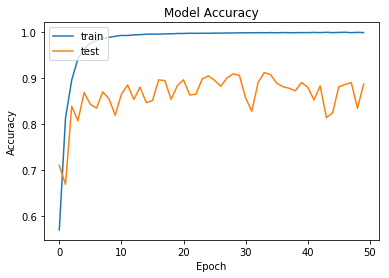

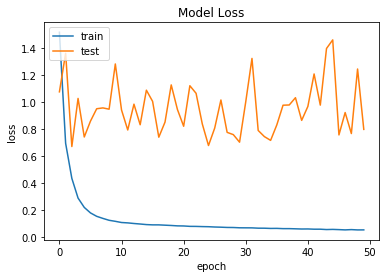

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

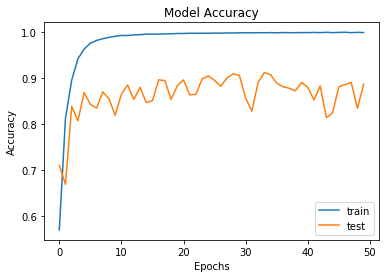

In [14]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

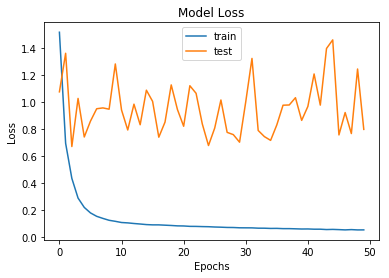

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

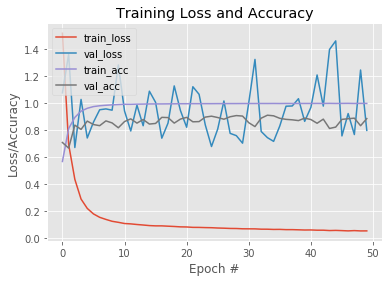

In [16]:
plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["categorical_accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_categorical_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

In [11]:
filename = validation_generator.filenames
truth = validation_generator.classes
label = validation_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

In [13]:
predicts = model.predict_generator(validation_generator, steps=validation_generator.samples/validation_generator.batch_size, verbose=1)
predict_class = np.argmax(predicts, axis=1)
errors = np.where(predict_class != truth)[0]
print("No of errors = {}/{}".format(len(errors),validation_generator.samples))

352/351 [==============================] - 3942s 11s/step
No of errors = 1272/11233


Confusion Matrix
[[1432   12   70    0   26   12    0]
 [  69 1563   38    1   12    9    0]
 [  40    4 1363    1   44   27    0]
 [  62   26   48 1441   20   35    0]
 [  14    4   52    1 1536   55    2]
 [  20    7   59    1  120 1522    1]
 [   0    8   32    0    0  340 1104]]


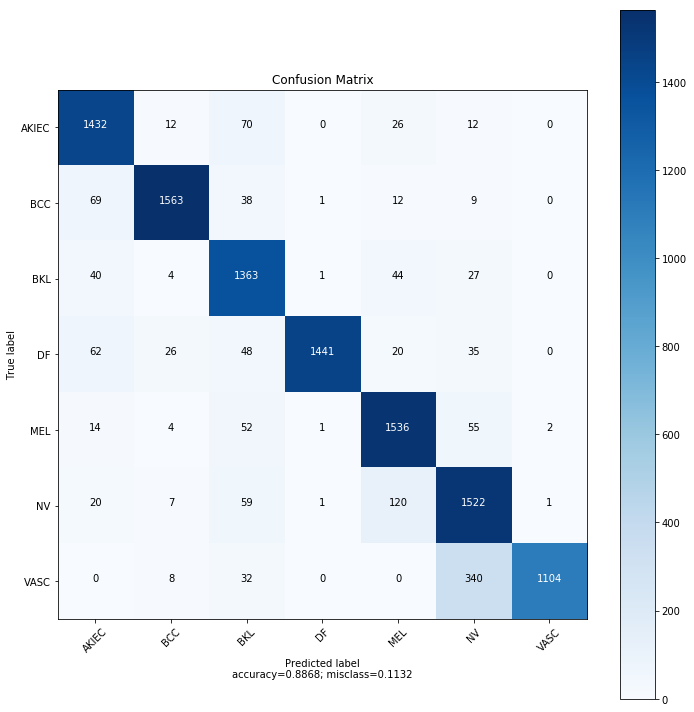

In [14]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth,predict_class)

labels = []
for k,v in indexlabel.items():
    labels.append(v)
    
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig('plots/5.VGG19-CM.png', bbox_inches='tight', dpi = 100)

plt.figure(figsize=(10,10))


plot_confusion_matrix(cm, classes=labels,
                      title='Confusion Matrix')

In [20]:
model.save('models/5.VGG19-Adam-Dropout-Model.h5')
model.save_weights('models/VGG19-Adam-Dropout-Weights.h5')

In [9]:
from keras.models import load_model
model = load_model("models/5.VGG19-Adam-Dropout-Model.h5", custom_objects={'fmeasure': fmeasure,  'recall': recall, 'precision': precision })
model.load_weights("models/VGG19-Adam-Dropout-Weights.h5")

____

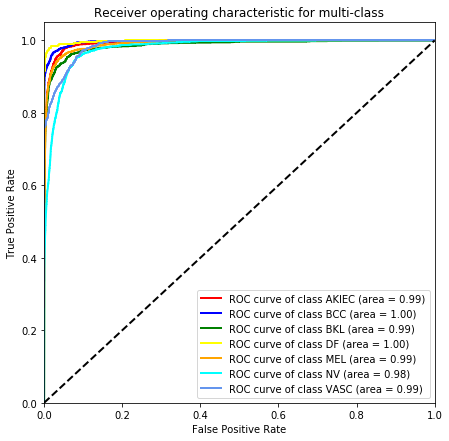

In [15]:
#ROC Curve for each class
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
%matplotlib inline  
from scipy import interp
from itertools import cycle




y_pred = predicts
y_pred_probabilities=y_pred

y_pred = np.argmax(y_pred,axis = 1) 
y_actual = validation_generator.classes

classnames=[]
for classname in validation_generator.class_indices:
    classnames.append(classname)

y_actual_binary = label_binarize(y_actual, classes=[0, 1, 2, 3, 4,5,6])
y_pred_binary = y_pred_probabilities#label_binarize(y_pred_probabilities, classes=[0, 1, 2, 3, 4])
n_classes=7
lw=2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_actual_binary[:, i], y_pred_binary[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_actual_binary.ravel(), y_pred_binary.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(7, 7))


colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class')
plt.legend(loc="best")
plt.show()

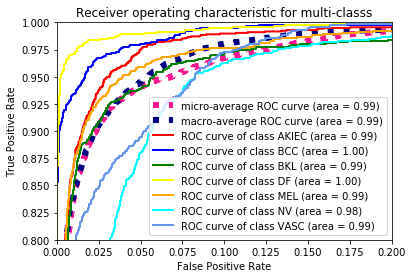

In [16]:
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=6)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=6)


colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

    
    
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-classs')
plt.legend(loc="lower right")
plt.savefig('plots/5.VGG19-ROC.png', dpi = 100)
plt.show()

In [19]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report



confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[1432   12   70    0   26   12    0]
 [  69 1563   38    1   12    9    0]
 [  40    4 1363    1   44   27    0]
 [  62   26   48 1441   20   35    0]
 [  14    4   52    1 1536   55    2]
 [  20    7   59    1  120 1522    1]
 [   0    8   32    0    0  340 1104]]
             precision    recall  f1-score   support

      AKIEC       0.87      0.92      0.90      1552
        BCC       0.96      0.92      0.94      1692
        BKL       0.82      0.92      0.87      1479
         DF       1.00      0.88      0.94      1632
        MEL       0.87      0.92      0.90      1664
         NV       0.76      0.88      0.82      1730
       VASC       1.00      0.74      0.85      1484

avg / total       0.90      0.89      0.89     11233



In [15]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_conv4
11 block3_pool
12 block4_conv1
13 block4_conv2
14 block4_conv3
15 block4_conv4
16 block4_pool
17 block5_conv1
18 block5_conv2
19 block5_conv3
20 block5_conv4
21 block5_pool
22 global_average_pooling2d_1
23 dense_1
24 batch_normalization_1
25 dropout_1
26 dense_2
27 batch_normalization_2
28 dropout_2
29 dense_3


In [16]:
from keras.callbacks import ModelCheckpoint,EarlyStopping, TensorBoard



# Part 2 - Fitting the CNN to the images

tensorboard=TensorBoard(log_dir='./logs/', histogram_freq=0, 
                         batch_size=32, write_graph=True, 
                         write_grads=True, write_images=True)

checkpointer = ModelCheckpoint(filepath='./output_models/Model{epoch:02d}_{val_acc:.2f}.h5', 
                               verbose=1, save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, 
                               patience=5, verbose=1, mode='auto')

classifier.fit_generator(training_set,
                         steps_per_epoch = 600,
                         epochs = 1000,
                         validation_data = test_set,
                         validation_steps = 30,
                         callbacks =[tensorboard,early_stopping,checkpointer])

NameError: name 'classifier' is not defined